# Test Case 6 - Single Inductance Not Connected to Ground

In [1]:
from CircuitCalculator.Circuit.state_space_model import state_space_model
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

## Setup Circuit

In [2]:
R1, R2, R3 = 10, 20, 30
L = 0.1
V0 = 5
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=V0, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.resistor(id='R2', R=R2, nodes=('2', '0')),
    cmp.inductance(id='L', L=L, nodes=('2', '3')),
    cmp.resistor(id='R3', R=R3, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])

In [3]:
network=transform_circuit(circuit, w=0)
network

Network(branches=[Branch(node1='1', node2='0', element=NortenElement(name='Uq', type='voltage_source', Z=0j, V=(5+0j))), Branch(node1='1', node2='2', element=NortenElement(name='R1', type='resistor', Z=10.0, V=0)), Branch(node1='2', node2='0', element=NortenElement(name='R2', type='resistor', Z=20.0, V=0)), Branch(node1='2', node2='3', element=NortenElement(name='L', type='impedance', Z=0j, V=0)), Branch(node1='3', node2='0', element=NortenElement(name='R3', type='resistor', Z=30.0, V=0))], node_zero_label='0')

In [4]:
def step(t: np.ndarray) -> np.ndarray:
    return np.heaviside(t, 1)

In [5]:
t_max = 0.02
t0 = 0.001
Ts = t_max/1000
t = np.arange(0, t_max, Ts)
V = V0*step(t-t0)

In [6]:
import itertools
from CircuitCalculator.Network.NodalAnalysis.label_mapping import default_node_mapper
node_mapping = default_node_mapper(network)
def element_incidence_matrix(values: dict[str, float]) -> np.ndarray:
    Delta = np.zeros((len(values), node_mapping.N))
    for (k, value), (i_label) in itertools.product(enumerate(values), node_mapping):
        if i_label == network[value].node1:
            Delta[k][node_mapping(i_label)] = +1
        if i_label == network[value].node2:
            Delta[k][node_mapping(i_label)] = -1
    return Delta

In [7]:
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *
import CircuitCalculator.Network.NodalAnalysis.label_mapping as map
from numpy.linalg import inv
voltage_source_mapper = map.alphabetic_voltage_source_mapper
def element_incidence_matrix(values: dict[str, float]) -> np.ndarray:
    Delta = np.zeros((len(values), node_mapping.N))
    for (k, value), (i_label) in itertools.product(enumerate(values), node_mapping):
        if i_label == network[value].node1:
            Delta[k][node_mapping(i_label)] = +1
        if i_label == network[value].node2:
            Delta[k][node_mapping(i_label)] = -1
    return np.hstack((Delta, np.zeros((Delta.shape[0], voltage_source_mapper(network).N))))

In [8]:
l_labels = {'L': L}

# Y = create_node_matrix_from_network(network)
A_tilde = nodal_analysis_coefficient_matrix(network).real

source_mapping = map.default_source_mapper(network)
Qi = source_incidence_matrix(
        network=network)


voltage_source_mapping = map.filter(voltage_source_mapper(network), lambda x: x not in l_labels)
inductance_mapping = map.filter(voltage_source_mapper(network), lambda x: x in l_labels)
voltage_source_mapping_all = voltage_source_mapper(network)

# Q = np.vstack((np.hstack((Qi, np.zeros((Qi.shape[0], voltage_source_mapping.N)))), np.hstack((np.zeros((1, Qi.shape[1])), np.eye(voltage_source_mapping.N)))))
# Q = np.array([[0, 0], [0, 0], [0, 0], [1, 0], [0, 1]])
# PS = np.array([[0], [1]])
# PL = np.array([[1], [0]])
# QS = Q@PS
# QL = Q@PL
# print(QL)

Q = np.zeros((voltage_source_mapping_all.N, voltage_source_mapping_all.N), dtype=int)
for l in voltage_source_mapping_all:
    Q[voltage_source_mapping_all[l]][voltage_source_mapping_all[l]] = 1
Q = np.vstack((np.zeros((node_mapping.N, voltage_source_mapping_all.N), dtype=int), Q))

QS = Q[:,voltage_source_mapping.values]
QL = Q[:,inductance_mapping.values]

QL = np.zeros((5, inductance_mapping.N), dtype=int)
for l in inductance_mapping:
    QL[node_mapping.N+inductance_mapping[l]][inductance_mapping[l]] = 1

L_inv = np.diag([1/L for L in l_labels.values()])

A = inv(QL.T@inv(A_tilde)@QL)@L_inv
B = -A * QL.T@inv(A_tilde)@QS
print(A)
print(B)

C = inv(A_tilde)@QL@inv(L_inv)@A
D = inv(A_tilde)@(QS+QL@inv(L_inv)@B)

[[-366.66666667]]
[[6.66666667]]


In [9]:
sys = signal.StateSpace(A, B, C, D)
tout, yout, out = signal.lsim(sys, V, t)

print(A)
print(B)

[[-366.66666667]]
[[6.66666667]]


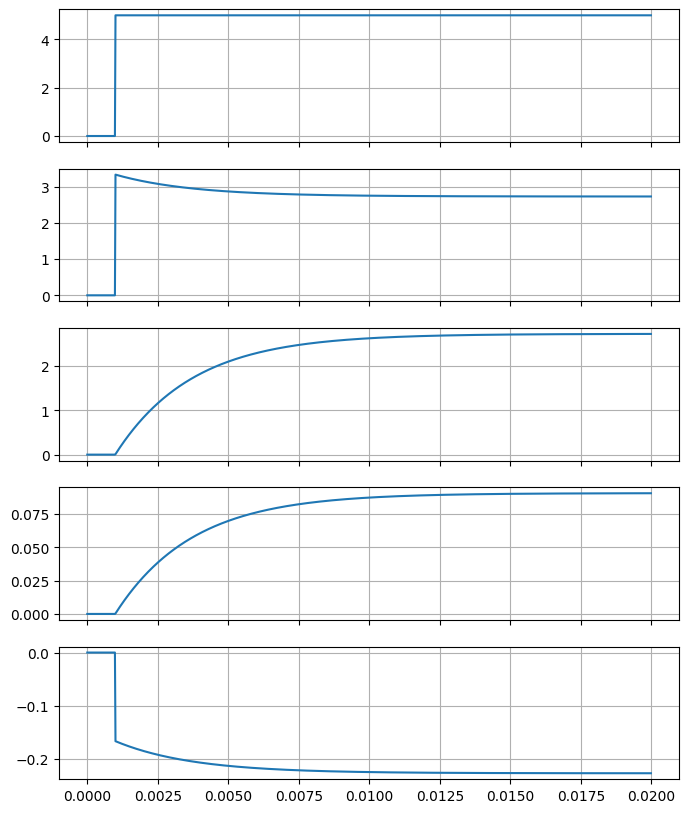

In [10]:
_, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 10))

ax[0].plot(tout, yout[:,0])
ax[0].grid(True)

ax[1].plot(tout, yout[:,1])
ax[1].grid(True)
# ax[1].set_ylim(-0.1, 3)

ax[2].plot(tout, yout[:,2])
ax[2].grid(True)

ax[3].plot(tout, yout[:,3])
ax[3].grid(True)

ax[4].plot(tout, yout[:,4])
ax[4].grid(True)